在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为$f$，自变量为一个二维向量$[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：

$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

在7.4节（动量法）里我们看到**当$x_1$和$x_2$的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散**。但这样会导致自变量在梯度值较小的维度上迭代过慢。**动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能**。本节我们介绍**AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题**[1]。

**注：都可以解决梯度不同导致的问题，但和动量法思路不一致。**

## 7.5.1 算法

AdaGrad算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，AdaGrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。**这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率**。

**注：为什么通过这样的设置，可以调整学习率，这个有些没想明白。。是因为，每个变量，都有自己的S_t嘛？**

## 7.5.2 特点

需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，**当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解**。

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

In [1]:
%matplotlib inline
import numpy as np
import time
import math
import sys
import tensorflow as tf
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l

epoch 20, x1 -2.382563, x2 -0.158591


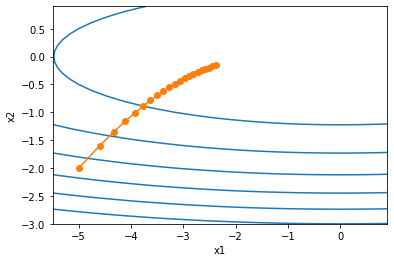

In [3]:
def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  #前两项为自变量梯度
    s1 += g1 **2
    s2 += g2 **2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return  x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1**2 + 2*x2**2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。

epoch 20, x1 -0.002295, x2 -0.000000


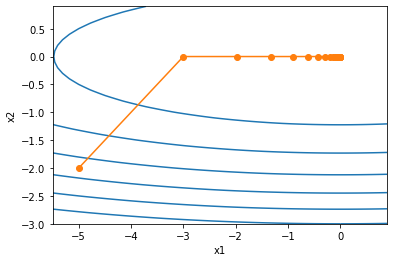

In [4]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 7.5.3 从零开始实现

同动量法一样，**AdaGrad算法需要对每个自变量维护同它一样形状的状态变量**。我们根据AdaGrad算法中的公式实现该算法。

In [5]:
features, labels = d2l.get_data_ch7()

def init_adagrad_states():
    s_w = tf.zeros((features.shape[1],1),dtype=tf.float32)
    s_b = tf.zeros(1,dtype=tf.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams, grads):
    eps = 1e-6
    i = 0
    for p, s in zip(params, states):
        s += (grads[i] **2)
        p.assign_sub(hyperparams['lr'] * grads[i]/tf.sqrt(s+eps))
        i += 1

与7.3节（小批量随机梯度下降）中的实验相比，这里使用更大的学习率来训练模型。

loss: 0.481372, 0.844414 sec per epoch


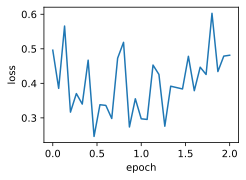

In [11]:
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

## 7.5.4 简洁实现

通过名称为`Adagrad`的优化器方法，我们便可使用Tensorflow2提供的AdaGrad算法来训练模型。

loss: 1.335473, 1.272290 sec per epoch


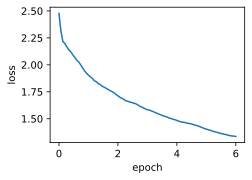

In [14]:
from tensorflow.keras import optimizers
trainer = optimizers.Adagrad(learning_rate=0.01)
d2l.train_tensorflow2_ch7(trainer,{'lr':0.01},
                         features,labels,num_epochs=6)

In [13]:
# d2l.train_tensorflow2_ch7??

loss: 0.886268, 1.528302 sec per epoch


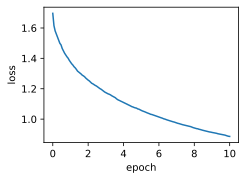

In [15]:
d2l.train_tensorflow2_ch7(trainer,{'lr':0.01},
                         features,labels,num_epochs=10)

## 小结

* AdaGrad算法**在迭代过程中不断调整学习率**，**并让目标函数自变量中每个元素都分别拥有自己的学习率**。
* 使用AdaGrad算法时，**自变量中每个元素的学习率在迭代过程中一直在降低（或不变）**。


## 参考文献

[1] Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive subgradient methods for online learning and stochastic optimization. Journal of Machine Learning Research, 12(Jul), 2121-2159.

-----------

> 注：除代码外本节与原书此节基本相同，[原书传送门](https://zh.d2l.ai/chapter_optimization/adagrad.html)

